In [1]:
!pip install segmentation-models

In [2]:
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
import glob

from matplotlib.pyplot import figure
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler

Segmentation Models: using `keras` framework.


In [3]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [4]:
temp_mask = cv2.imread('C:/Users/himan/Downloads/VegetationMonitoring/rs19_val/uint8/rs19_val/rs00000.png') #3 channels but all same. 
labels, count = np.unique(temp_mask[:,:,0], return_counts=True) #Check for each channel. All chanels are identical
print("Labels are: ", labels, " and the counts are: ", count)

Labels are:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  24  30  33  41  43  47  49  55  57  65  95 127 128 133 144 146 149 159
 170 174 180 184 193 229 235 238 240 244 245 248 253 254 255]  and the counts are:  [ 827  146   42   30   29  282  145  211 5101 1145 4911   22  823   87
   94 1844  237  237    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    2    1    1
    1    1    1    1    1    2    1    1  137]


In [5]:
#width and length of the images
w = temp_mask.shape[0]
l = temp_mask.shape[1]

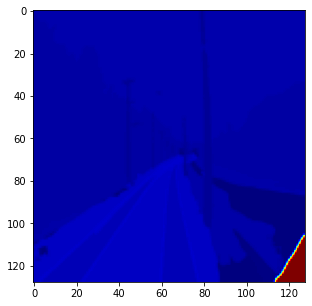

In [6]:
plt.figure(figsize = (10,5))
#before processing
plt.imshow(temp_mask[:,:,0], cmap='jet')

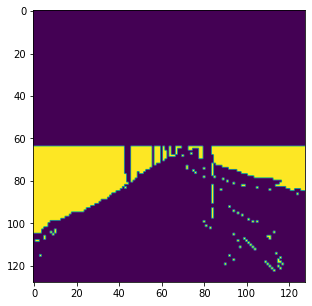

In [7]:
#temp_mask = cv2.imread('rC:/Users/himan/Downloads/VegetationMonitoring/rs19_val/uint8/rs19_val/rs00000.png')
plt.figure(figsize = (10,5))
label_of_interest = 8 #veg
#after processing
temp_mask[:int(w/2),:,0]=0
temp_mask[:,:,0][temp_mask[:,:,0]!=label_of_interest]=0
plt.imshow(temp_mask[:,:,0])

In [8]:
len(np.unique(temp_mask[:,:,0]))

2

In [9]:
#scaler = MinMaxScaler()

In [10]:
#test_image_data=scaler.fit_transform(image_dataset_uint8.reshape(-1, image_dataset_uint8.shape[-1])).reshape(image_dataset_uint8.shape)

image:  (1000, 128, 128, 3)
mask:  (1000, 128, 128)
image:  (1000, 128, 128, 3)
mask:  (1000, 128, 128, 1)
unique labels in mask [0 1]


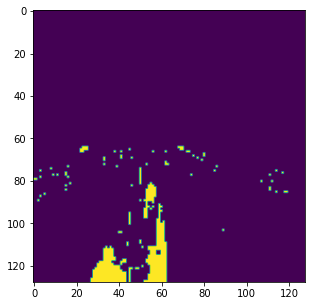

In [11]:
#these codes are used to loop through the directory
path_images = 'C:/Users/himan/Downloads/VegetationMonitoring/rs19_val/jpgs/rs19_val/'
path_mask = 'C:/Users/himan/Downloads/VegetationMonitoring/rs19_val/uint8/rs19_val/'
breaker = 0

image_dataset = []
mask_dataset = []

label_of_interest = 8 #veg
plt.figure(figsize = (10,5))

for filename in os.listdir(path_images):
    breaker +=1
    if filename.endswith('.jpg'):  
        image = cv2.imread(path_images+filename) 
        mask = cv2.imread(path_mask+filename[:7]+'.png')
        for layer in range(len(mask[0,0,:])):
            #mask[:int(w/2),:,layer]=0
            mask[:,:,layer][mask[:,:,layer]!=label_of_interest]=0
            mask[:,:,layer][mask[:,:,layer]==label_of_interest]=1
                #this is because one hot encoder can only deal with 0 and 1 if there is 2 labels
        # image = np.array(image)
        # mask = np.array(mask)
        image_dataset.append(image)
        mask_dataset.append(mask)
    if breaker==1000:
         break

image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)
mask_dataset = mask_dataset[:,:,:,0]
print('image: ', image_dataset.shape)
print('mask: ', mask_dataset.shape)
plt.imshow(mask[:,:,0])

mask_dataset = np.expand_dims(mask_dataset, axis=3)
print('image: ', image_dataset.shape)
print('mask: ', mask_dataset.shape)

print('unique labels in mask', np.unique(mask_dataset))

In [12]:
#Normalize images
image_dataset = image_dataset /255.  #Can also normalize or scale using MinMax scaler
#Do not normalize masks, just rescale to 0 to 1.
mask_dataset = mask_dataset /255.  #PIxel values will be 0 or 1

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)


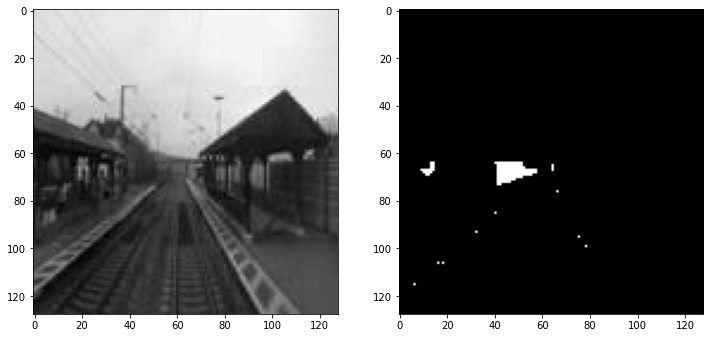

In [14]:
#Sanity check, view few mages
import random

image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0], cmap='gray')
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap='gray')
plt.show()

In [15]:
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [16]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [17]:
model = build_unet(input_shape, n_classes=1)
model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

sigmoid
Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________

In [19]:
history = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=200, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)


Epoch 1/200
50/50 [==============================] - 45s 897ms/step - loss: 0.0990 - accuracy: 0.9165 - val_loss: 7.3607 - val_accuracy: 0.0678
Epoch 2/200
50/50 [==============================] - 38s 763ms/step - loss: 0.0511 - accuracy: 0.9166 - val_loss: 1.2102 - val_accuracy: 0.4851
Epoch 3/200
50/50 [==============================] - 38s 762ms/step - loss: 0.0325 - accuracy: 0.9167 - val_loss: 0.0780 - val_accuracy: 0.9300
Epoch 4/200
50/50 [==============================] - 38s 762ms/step - loss: 0.0228 - accuracy: 0.9167 - val_loss: 0.0440 - val_accuracy: 0.9300
Epoch 5/200
50/50 [==============================] - 38s 763ms/step - loss: 0.0170 - accuracy: 0.9167 - val_loss: 0.0266 - val_accuracy: 0.9300
Epoch 6/200
50/50 [==============================] - 38s 763ms/step - loss: 0.0133 - accuracy: 0.9167 - val_loss: 0.0184 - val_accuracy: 0.9300
Epoch 7/200
50/50 [==============================] - 38s 762ms/step - loss: 0.0108 - accuracy: 0.9167 - val_loss: 0.0135 - val_accuracy:

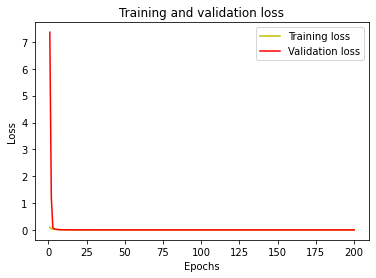

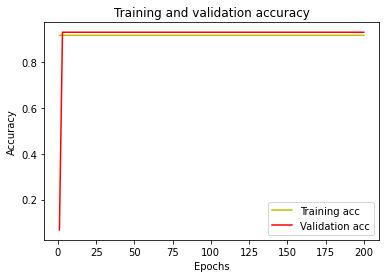

In [20]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

In [22]:
from tensorflow.keras.metrics import MeanIoU

In [23]:
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 1.0


(1, 128, 128, 3)
(128, 128)


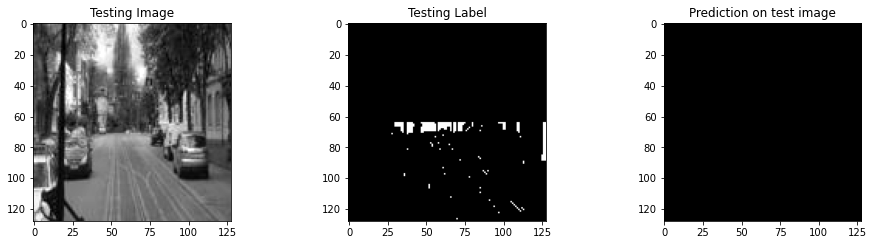

In [24]:
threshold = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()